Kaggle Competition MATH

Setting up Kaggle

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"mitchellkarkheck","key":"de03ad486e884e040f1469d76d821a7c"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets list

ref                                                                       title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
datasets/piterfm/2022-ukraine-russian-war                                 2022 Ukraine Russia War                              1KB  2022-03-28 08:25:57           3148        212  1.0              
datasets/prasertk/healthy-lifestyle-cities-report-2021                    Healthy Lifestyle Cities Report 2021                 2KB  2022-03-03 00:26:02           3182         98  1.0              
datasets/kamilpytlak/personal-key-indicators-of-heart-disease             Personal Key Indicators of Heart Disease             3MB  2022-02-16 10:18:03           5338        112  1.0              
datasets/vivek4

In [ ]:
data_path = !kaggle competitions download -c math80600a-2022w

In [ ]:
#installs
!pip install transformers
!pip install torchtext==0.9.0
!pip install numpy requests nlpaug
!pip install torch>=1.8.0 fairseq>=0.9.0 sacremoses>=0.0.43 fastBPE>=0.1.0

In [ ]:
#imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

#data augmentation imports
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import time

#sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#torch imports
import torch
from torch.utils.data import random_split
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

In [ ]:
!unzip math80600a-2022w.zip

Archive:  math80600a-2022w.zip
replace nodeid2paperid.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: nodeid2paperid.csv      
replace sample.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sample.csv              
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                
replace text.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: text.csv                
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


In [ ]:
#data path for kaggle
data_path = '../content/'
output_path = './'

In [ ]:
#save data files as dataframes
trainfile = f"{data_path}train.csv"
testfile = f"{data_path}test.csv"
nodeid2paperidfile = f"{data_path}nodeid2paperid.csv"
textfile = f"{data_path}text.csv"

traindf = pd.read_csv(trainfile,names=['label', 'node idx'])
testdf = pd.read_csv(testfile,names=['node idx'])
nodeid2paperiddf = pd.read_csv(nodeid2paperidfile)
textdf = pd.read_csv(textfile, names=['paper id', 'title', 'abstract'])

In [ ]:
#join dataframes together
# training
train = pd.merge(nodeid2paperiddf ,textdf,  how = 'left', on = 'paper id')
trainmerged = pd.merge(traindf,train,  how = 'left', on = 'node idx')
trainmerged.drop(['node idx','paper id'], axis=1,inplace=True)

# testing
test = pd.merge(nodeid2paperiddf ,textdf,  how = 'left', on = 'paper id')
testmerged = pd.merge(testdf,test,  how = 'left', on = 'node idx')
testmerged.drop(['paper id'], axis=1,inplace=True)



In [ ]:
#Data tokenizing for cleaning
import re

def RegexpTokenizer(text):
    reg = text
    reg = re.sub(' +', ' ',reg, re.MULTILINE)
    reg = re.sub(r"(\$+)(?:(?!\1)[\s\S])*\1", "", reg, re.MULTILINE)
    reg = re.sub(r'\\url{([^}]*)}', "", reg, re.MULTILINE)
    reg = re.sub(r'\\emph{([^}]*)}', "\\1", reg, re.MULTILINE)
    reg = re.sub(r'\\textit{([^}]*)}',"\\1", reg, re.MULTILINE)
    reg = re.sub(r'\\quotes{([^}]*)}',"\\1", reg, re.MULTILINE)
    reg = re.sub(r'\\texttt{([^}]*)}',"\\1", reg, re.MULTILINE)
    reg = re.sub("[^0-9a-zA-Z]+"," ",reg, re.MULTILINE)
    reg = re.sub(' +', ' ',reg, re.MULTILINE)

    return reg

In [ ]:
#add fake label in the test set in order to use the evaluation function
testmerged.insert(1,'label', 0, False)

In [ ]:
#export cleaned data
trainmerged.to_csv(f'{output_path}traincleaned.csv', index=False)
testmerged.to_csv(f'{output_path}testcleaned.csv', index=False)

In [ ]:
# function to augment training dataset
def TextAugmTranslate(df, label=12, iter=1):
  # use uncased roberta word embeddings for substitute word replacements for augmentation
  Substitutewords = naw.context_word_embs.ContextualWordEmbsAug(model_path='roberta-base', model_type='', action='substitute', temperature=1.0, top_k=100, top_p=None,
                                                              name='ContextualWordEmbs_Aug', aug_min=1, aug_max=10, aug_p=0.3, stopwords=None, device='cuda',
                                                              force_reload=False, optimize=None, stopwords_regex=None, verbose=0, silence=True)

  for i in range(iter):
    start = time.time()
    print(f"iter {i} | init shape : {df[df['label']==label].shape} of label {label} | start time {time.asctime( time.localtime(start))}")
    train_aug = df[df['label']==label].copy()
    temp = df.copy()

    train_aug['title'] = train_aug['title'].apply(lambda x: Substitutewords.augment(x)) # word substitute for new titles
    train_aug['abstract'] = train_aug['abstract'].apply(lambda x: Substitutewordsy.augment(x)) # word substitute for new abstracts

    temp = pd.concat([temp,train_aug], ignore_index=True)
    df = temp
    end = time.time()

    print(f"new shape : {df[df['label']==label].shape} of label {label} | end time {time.asctime( time.localtime(end))}")

  return df

In [ ]:
# load CSV with dataset
train = pd.read_csv(f"{output_path}traincleaned.csv")
test = pd.read_csv(f"{output_path}testcleaned.csv")

In [ ]:
# split train dataset into train, validation sets
train, valid= train_test_split(train,random_state=80600, test_size=0.2,shuffle =True, stratify=train['label'])

In [ ]:
#concatenate title and abstract
train['LongSentence'] = train['title'] + " " + train['abstract']
valid['LongSentence'] = valid['title'] + " " + valid['abstract']
test['LongSentence'] = test['title'] + " " + test['abstract']

In [ ]:
#save preprocessed data to csv's
train.to_csv(f"{output_path}preptrainaug.csv")
valid.to_csv(f"{output_path}prepval.csv")
test.to_csv(f"{output_path}preptest.csv")

In [ ]:
#set random seed and device to GPU
torch.manual_seed(7)

if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device('cpu')

print(device)

cuda


In [ ]:
#download SciBERT. a BERT model trained on scientific papers and use bertTokenizer
do_lower_case = True

MODEL_NAME = 'allenai/scibert_scivocab_uncased'
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME, do_lower_case=do_lower_case)

In [ ]:
#set tokenizer hyperparameters
MAX_SEQ_LEN = 512
BATCH_SIZE = 16

PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)


# Define columns to read.
label_field = Field(sequential=False, use_vocab=False, batch_first=True)
text_field = Field(use_vocab=False,
                   tokenize=tokenizer.encode,
                   include_lengths=False,
                   batch_first=True,
                   fix_length=MAX_SEQ_LEN,
                   pad_token=PAD_INDEX,
                   unk_token=UNK_INDEX)

fields = {'LongSentence' : ('LongSentence', text_field), 'label' : ('label', label_field)}

#read preprocessed CSV into tabular form and split it into train, test and validation
traindata = TabularDataset(path=f"{output_path}/preptrainaug.csv", format='CSV', fields=fields,
                                                   skip_header=False)

validdata = TabularDataset(path=f"{output_path}/prepval.csv", format='CSV', fields=fields,
                                                   skip_header=False)

testdata = TabularDataset(path=f"{output_path}/preptest.csv", format='CSV', fields=fields,
                                                   skip_header=False)

#create train and validation iterators
trainiter, validiter = BucketIterator.splits((traindata, validdata),
                                               batch_size=BATCH_SIZE,
                                               device=device,
                                               shuffle=True,
                                               sort_key=lambda x: len(x.LongSentence),
                                               sort=True,
                                               sort_within_batch=False)

#create test iterator with no shuffling/sorting
testiter = Iterator(testdata, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [ ]:
#functions for saving and loading model parameters and loss metrics
def save_checkpoint(path, model, valid_loss):
    torch.save({'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}, path)

def load_checkpoint(path, model):
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict['model_state_dict'])

    return state_dict['valid_loss']

def save_metrics(path, train_loss_list, valid_loss_list, global_steps_list):
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}

    torch.save(state_dict, path)

def load_metrics(path):
    state_dict = torch.load(path, map_location=device)
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [ ]:
# Model with 2 linear layers with dropout and normalization added on top of pretrained SciBERT from allen ai
class SciBERTClassifier(torch.nn.Module):
    def __init__(self, dropout_rate=0.3): #dropout rate of 0.3
        super(SciBERTClassifier, self).__init__()

        self.SciBERT = BertModel.from_pretrained('allenai/scibert_scivocab_uncased')
        self.d1 = torch.nn.Dropout(dropout_rate)
        self.l1 = torch.nn.Linear(768, 64) #784 in channels and 64 out
        self.bn1 = torch.nn.LayerNorm(64)
        self.d2 = torch.nn.Dropout(dropout_rate)
        self.l2 = torch.nn.Linear(64, 20) # 64 in channels and 20 out

    def forward(self, input_ids, attention_mask):
        text = self.SciBERT(input_ids=input_ids, attention_mask=attention_mask)
        text = text[1]
        text = self.d1(text)
        text = self.l1(text)
        text = self.bn1(text)
        text = torch.nn.Tanh()(text)
        text = self.d2(text)
        text = self.l2(text)
        #print(text.shape)
        return text

In [ ]:
#define pretraining function
def pretrain(model,
             optimizer,
             trainiter,
             validiter,
             scheduler = None,
             valid_period = len(trainiter),
             num_epochs = 5):

    # Pretrain just linear layers
    for param in model.SciBERT.parameters():
        param.requires_grad = False

    model.train()

    # Initialize losses and loss histories
    train_loss = 0.0
    valid_loss = 0.0

    global_step = 0

    # Training loop
    for epoch in range(num_epochs):
        for (source, target), _ in trainiter:
            mask = (source != PAD_INDEX).type(torch.uint8)

            logits = model(input_ids=source,
                           attention_mask=mask)

            y_pred = torch.max(logits, dim=-1)[1]
            loss = torch.nn.CrossEntropyLoss()(logits, target)
            loss.backward()

            # optimizer and scheduler step
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop to save progress and evaluate model performance
            if global_step % valid_period == 0:
                model.eval()

                with torch.no_grad():
                    for (source, target), _ in validiter:
                        mask = (source != PAD_INDEX).type(torch.uint8)
                        logits = model(input_ids = source,
                                       attention_mask = mask)

                        y_pred = torch.max(logits, dim =-1)[1]
                        loss = torch.nn.CrossEntropyLoss()(logits, target)
                        valid_loss += loss.item()

                # Store train and validation loss history
                train_loss = train_loss / valid_period
                valid_loss = valid_loss / len(validiter)
                model.train()

                # print summary
                print("Epoch [{}/{}], global step [{}/{}], PreTrain Loss: {:.4f}, Val Loss: {:.4f}"
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(trainiter),
                              train_loss, valid_loss))

                train_loss = 0.0
                valid_loss = 0.0

    #set bert parameters back to trainable
    for param in model.SciBERT.parameters():
        param.requires_grad = True

    print("Pretraining done!")

In [ ]:
# defining the training function

def train(model, optimizer, trainiter, validiter,
                  scheduler = None,
                  num_epochs = 5,
                  valid_period = len(trainiter),
                  output_path = output_path):

    # Initialize losses, history and global steps
    train_loss = 0.0
    valid_loss = 0.0
    train_loss_list = []
    valid_loss_list = []
    best_valid_loss = float('Inf')
    global_step = 0
    global_steps_list = []

    model.train()

    # Training loop
    for epoch in range(num_epochs):
        for (source, target), _ in trainiter:
            mask = (source != PAD_INDEX).type(torch.uint8)

            logits = model(input_ids=source,
                           attention_mask=mask)

            y_pred = torch.max(logits, dim=-1)[1]
            loss = torch.nn.CrossEntropyLoss()(logits, target)
            loss.backward()
            # Optimizer and scheduler step
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop to save progress and evaluate model performance
            if global_step % valid_period == 0:
                model.eval()

                with torch.no_grad():
                    for (source, target), _ in validiter:
                        mask = (source != PAD_INDEX).type(torch.uint8)

                        logits = model(input_ids=source,
                                       attention_mask=mask)

                        y_pred = torch.max(logits, dim=-1)[1]
                        loss = torch.nn.CrossEntropyLoss()(logits, target)
                        valid_loss += loss.item()

                # Store train and validation loss history
                train_loss = train_loss / valid_period
                valid_loss = valid_loss / len(validiter)
                train_loss_list.append(train_loss)
                valid_loss_list.append(valid_loss)
                global_steps_list.append(global_step)

                # print summary
                print("Epoch [{}/{}], global step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}"
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(trainiter),
                              train_loss, valid_loss))

                # saving best model checkpoint
                if best_valid_loss > valid_loss:
                    best_valid_loss = valid_loss
                    save_checkpoint(output_path + 'model.pkl', model, best_valid_loss)
                    save_metrics(output_path + 'metric.pkl', train_loss_list, valid_loss_list, global_steps_list)

                train_loss = 0.0
                valid_loss = 0.0

                model.train()

    save_metrics(output_path + 'metric.pkl', train_loss_list, valid_loss_list, global_steps_list)
    print("training done!")

In [ ]:
#main training loop
#different learning rates for pretraining and training optimizer
NUM_EPOCHS = 9

steps_per_epoch = len(trainiter)

model = SciBERTClassifier(0.4)
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-4)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=steps_per_epoch*1,
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)

print("Start Pretraining!")

pretrain(model=model,
         trainiter=trainiter,
         validiter=validiter,
         optimizer=optimizer,
         scheduler=scheduler,
         num_epochs=NUM_EPOCHS)

NUM_EPOCHS = 9
print("Start Training!")
optimizer = AdamW(model.parameters(), lr=2e-6)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=steps_per_epoch*2,
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)

train(model=model,
      trainiter=trainiter,
      validiter=validiter,
      optimizer=optimizer,
      scheduler=scheduler,
      num_epochs=NUM_EPOCHS)

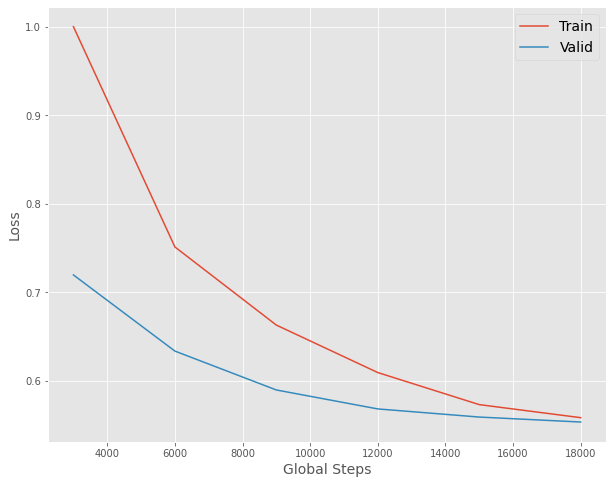

In [ ]:
plt.figure(figsize=(10, 8))
train_loss_list, valid_loss_list, global_steps_list = load_metrics(output_path + 'metric.pkl')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [ ]:
# Evaluation Function to look at class accuracies

def evaluate(model, val_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (source, target), _ in val_loader:
                mask = (source != PAD_INDEX).type(torch.uint8)

                output = model(source, attention_mask=mask)

                preds= torch.max(output, axis=-1)[1]
                y_pred += preds.tolist()
                y_true += target.tolist()

    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=range(20), digits=4))

    plt.figure(figsize=(15, 15))
    cm = confusion_matrix(y_true, y_pred, labels=range(20))
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap="YlGnBu", fmt="d")
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.xaxis.set_ticklabels(range(20))
    ax.yaxis.set_ticklabels(range(20))

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Classification Report:
              precision    recall  f1-score   support

           0     0.6667    0.4835    0.5605        91
           1     0.7895    0.1339    0.2290       112
           2     0.8446    0.8712    0.8577       792
           3     0.6400    0.6687    0.6540       335
           4     0.8017    0.8895    0.8433       959
           5     0.7938    0.8275    0.8103       800
           6     0.6037    0.6221    0.6128       262
           7     0.6364    0.0761    0.1359        92
           8     0.8591    0.8845    0.8716      1013
           9     0.8538    0.8575    0.8556       463
          10     0.7736    0.7966    0.7849      1278
          11     0.0000    0.0000    0.0000       124
          12     0.0000    0.0000    0.0000         5
          13     0.7322    0.6907    0.7109       388
          14     0.8022    0.7374    0.7684        99
          15     1.0000    0.3134    0.4773        67
          16     0.9409    0.9701    0.9552      4444
    

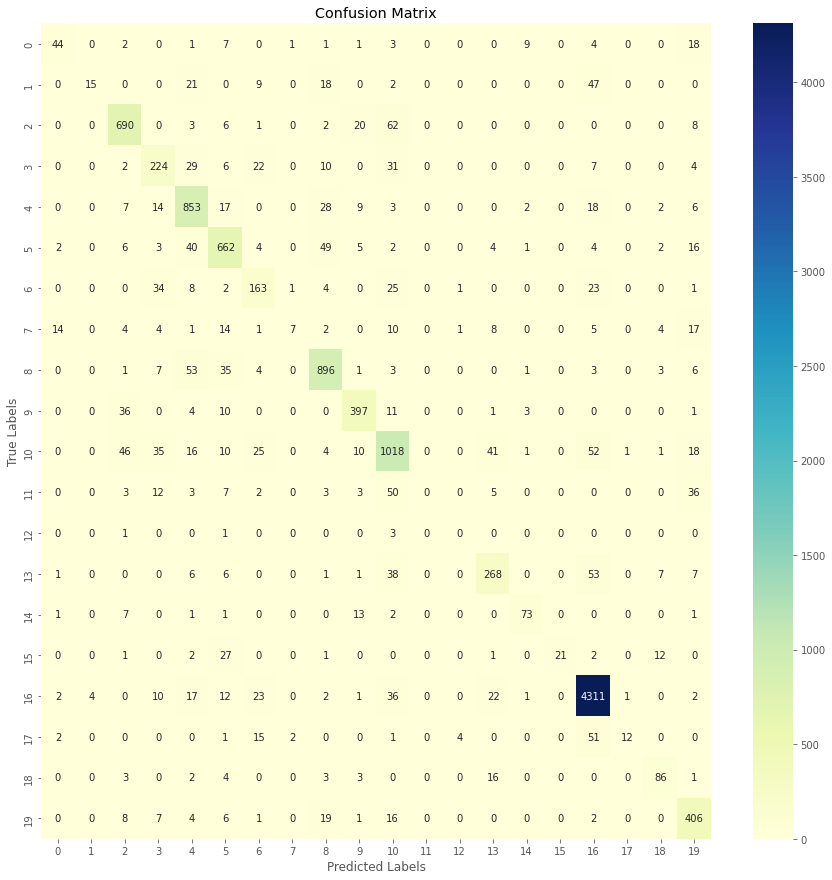

In [ ]:
model = SciBERTClassifier()
model = model.to(device)

load_checkpoint(output_path + 'model.pkl', model)

evaluate(model, validiter)

In [ ]:
test = pd.read_csv(f"{output_path}prep_test.csv")

In [ ]:
#Submission function
def get_submission(model, test_loader, test_ids):
    all_preds=[]
    model.eval()
    with torch.no_grad():
      for (source, target), _ in test_loader:
                mask = (source != PAD_INDEX).type(torch.uint8)

                output = model(source, attention_mask=mask)
                preds= torch.max(output, axis=-1)[1]
                all_preds += preds.tolist()
                #print(len(all_preds))
    #test dataframe with prediction()
    df= pd.DataFrame({
        "id" : test_ids.values,
        "label" : np.array(all_preds)
    })

    df.to_csv(f"submission.csv",index=False)

In [ ]:
get_submission(model,test_iter, test['node idx'])

In [ ]:
!kaggle competitions submit -c math80600a-2022w -f submission.csv -m "SciBERT"

100% 128k/128k [00:02<00:00, 52.9kB/s]
Successfully submitted to Math80600A W22 HWK2